# Inferential Insights into King County Housing Prices

For this project, our goal is to build a model that provides inferential insights into real-world housing data.

## PROJECT GOAL

Stakeholders in King County, WA have requested statistical analysis to validate several claims about housing prices in the most recent full calendar year, 2019.

These claims can be addressed directly with the three datasets (from the King County Department of Assessments) described later in this document:

1. Higher square footage increases home sale price?
2. Having a porch increases home sale price?
3. Having a beachfront or lakefront increases home sale price?
4. The presence of a nuisance (power lines, traffic noise, airport noise) decreases home sale price?

We will build a linear regression model to represent sales prices in King County, and use it to address these claims as well find other features that have a correlation with  home sale price.

We will specifically be focusing on finding what features of a house can increase home sale price and suggest to a house flipper what they can do to add value to a house.


# Import Libraries

In [64]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import zipfile
import os
import sys

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import my_functions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import Data

In [2]:
# ! wget -P ../../data/raw https://aqua.kingcounty.gov/extranet/assessor/Parcel.zip
# ! wget -P ../../data/raw https://aqua.kingcounty.gov/extranet/assessor/Real%20Property%20Sales.zip
# ! wget -P ../../data/raw https://aqua.kingcounty.gov/extranet/assessor/Residential%20Building.zip

In [3]:
# with zipfile.ZipFile('../../data/raw/Parcel.zip', 'r') as zip_ref:
#     zip_ref.extractall('../../data/raw')
# with zipfile.ZipFile('../../data/raw/Real Property Sales.zip', 'r') as zip_ref:
#     zip_ref.extractall('../../data/raw')
# with zipfile.ZipFile('../../data/raw/Residential Building.zip', 'r') as zip_ref:
#     zip_ref.extractall('../../data/raw')

In [4]:
parcel = pd.read_csv("../../data/raw/EXTR_Parcel.csv", encoding='latin-1')
real_property_sales = pd.read_csv("../../data/raw/EXTR_RPSale.csv", encoding='latin-1', low_memory=False)
residential_building = pd.read_csv("../../data/raw/EXTR_ResBldg.csv", encoding='latin-1', low_memory=False)

# Clean Data and Filter For Needed Info

### Property Sales

In [5]:
# Real Property Sales
# Identifyers are Major and Minor. Relevant data is SalePrice
# Clean real_property_sales to have proper values in Minor and Major and change type to int to match other data sets
real_property_sales = real_property_sales[['Major', 'Minor', 'SalePrice', 'DocumentDate']]
real_property_sales = real_property_sales[(real_property_sales['Major'].str.isdecimal()==True) &
                                          (real_property_sales['Minor'].str.isdecimal()==True)]
real_property_sales['Major'] = real_property_sales['Major'].astype('int64')
real_property_sales['Minor'] = real_property_sales['Minor'].astype('int64')
real_property_sales = real_property_sales[real_property_sales['SalePrice']>0]

### Parcel

In [6]:
# parcel.info()

In [7]:
# Parcel Filter for Necessary Columns
parcel = parcel[['Major', 'Minor', 'PropType', 'SqFtLot', 'WfntLocation',
                 'TrafficNoise', 'AirportNoise', 'PowerLines', 'OtherNuisances',
                 'MtRainier', 'Olympics', 'Cascades', 'PugetSound', 'LakeWashington',
                 'LakeSammamish', 'SmallLakeRiverCreek','SeattleSkyline']]

In [8]:
#Filter for R - residential and K - Condos
parcel = parcel[(parcel['PropType']=='R') | (parcel['PropType']=='K')]

In [9]:
# Seattle Sky Line column has multiple values so changing to 1 and 0
parcel['SeattleSkyline'] = [1 if i>0 else 0 for i in parcel.SeattleSkyline]

In [10]:
#Create Nuisances Column combining all nuisances and map 1, 0 values to Y and N for PowerLines and Other Nuisances
parcel['Nuisances'] = 'No Nuisances'
parcel.loc[(parcel['TrafficNoise']>0), 'Nuisances'] = 'Traffic Noise'
parcel.loc[(parcel['AirportNoise']>0), 'Nuisances'] = 'Airport Noise'
parcel.loc[(parcel['PowerLines']=='Y'), 'Nuisances'] = 'Power Lines'
parcel.loc[(parcel['OtherNuisances']=='Y'), 'Nuisances'] = 'Other Nuisances'
parcel['PowerLines'] = parcel['PowerLines'].map({'Y' : 1, 'N' : 0})
parcel['OtherNuisances'] = parcel['OtherNuisances'].map({'Y' : 1, 'N' : 0})
parcel['Has_Nuisance'] = [0 if n == 'No Nuisances' else 1 for n in parcel['Nuisances']]

# Drop Unecessary columns from parcel
parcel = parcel.drop(['PropType', 'AirportNoise'], axis='columns')

In [11]:
# WFNTLOCATION map to contain water names and create Is_Saterfront column
# Waterfront location (Source: King County Assessments)
# Value	Definition
# 0	Unknown
# 1	Duwamish
# 2	Elliott Bay
# 3	Puget Sound
# 4	Lake Union
# 5	Ship Canal
# 6	Lake Washington
# 7	Lake Sammamish
# 8	Other lake
# 9	River or slough

parcel['WaterFrontLocation'] = parcel.WfntLocation.map({0 : 'None', 1 : 'Duwamish', 2 : 'Elliott Bay', 3 : 'Puget Sound', 4 : 'Lake Union',
                     5 : 'Ship Canal',  6 : 'Lake Washington', 7 : 'Lake Sammamish', 8 : 'Other lake', 9 : 'River or slough'})
parcel['Is_WaterFrontLocation'] = [1 if i>0 else 0 for i in parcel.WfntLocation]
parcel=parcel.drop('WfntLocation', axis='columns')

### Residential Buiding

In [12]:
# residential_building.info()

In [13]:
# Residential Buiding Filter For Necessary Columns
residential_building = residential_building[['Major', 'Minor', 'ZipCode', 'SqFtTotLiving', 'SqFtOpenPorch',
                                             'SqFtEnclosedPorch', 'SqFtFinBasement', 'SqFtGarageAttached',
                                             'BldgGrade', 'SqFtDeck']]

In [14]:
# Create column Has_Porch, Has_OpenPorch, Has_OpenPorch
residential_building['Has_Porch']= residential_building['SqFtOpenPorch'] + residential_building['SqFtEnclosedPorch']
residential_building['Has_Porch'] = [1  if p>0 else 0 for p in residential_building['Has_Porch']]
residential_building['Has_OpenPorch'] = [1  if p>0 else 0 for p in residential_building['SqFtOpenPorch']]
residential_building['Has_EnclosedPorch'] = [1  if p>0 else 0 for p in residential_building['SqFtEnclosedPorch']]

# Drop Unecessary columns from residential_building
residential_building = residential_building.drop(['SqFtOpenPorch', 'SqFtEnclosedPorch'], axis='columns')

In [15]:
# Create a column Has_Deck
residential_building['Has_Deck'] = [1  if d>0 else 0 for d in residential_building['SqFtDeck']]

# Create a column Has_Finished_Basement
residential_building['Has_Finished_Basement'] = [1  if b>0 else 0 for b in residential_building['SqFtFinBasement']]

# Create a column Has_Attached_Garage
residential_building['Has_Attached_Garage'] = [1  if g>0 else 0 for g in residential_building['SqFtGarageAttached']]

# Drop Unecessary columns from residential_building
residential_building = residential_building.drop(['SqFtDeck', 'SqFtFinBasement', 'SqFtGarageAttached'], axis='columns')

In [16]:
# Builing Grade column - remap to make more sense according to description
# 1 : 'Poor'
# 2 : 'Low',
# 3 : 'Fair'
# 4 : 'Low-Average'
# 5 : 'Average'
# 6 : 'Good'
# 7 : 'Better'
# 8 : 'Very Good'
# 9 : 'Cabin',
# 10 : 'Excellent'
# 11 : 'Luxury'
# 12 : 'Mansion'

residential_building['BldgGrade'] = residential_building.BldgGrade.map({3 : 1, 4 : 2, 5 : 3,  6 : 4, 7 : 5, 8 : 6, 9 : 7, 10 : 8,
                                    1: 9, 11 : 10, 12 : 11, 13 : 12})

### Merge Property Sales, parcel, and residential building data

In [17]:
# Join all the tables on Major, Minor
merged_tables = (parcel.merge(real_property_sales, on = ['Major', 'Minor'])).merge(residential_building, on = ['Major', 'Minor']).drop_duplicates()

# Change dates to date time format
merged_tables[['Major', 'SqFtLot']].head(20)
merged_tables['DocumentDate'] = pd.to_datetime(merged_tables['DocumentDate'])

In [18]:
merged_tables.shape

(991786, 29)

In [19]:
#Keeping only the most recent Sale_Price For each residence
merged_tables = merged_tables.sort_values(by=['Major', 'DocumentDate'])
merged_tables.drop_duplicates(subset=['Major', 'Minor'], keep='last', inplace=True)
merged_tables.shape

(447186, 29)

In [20]:
# Filtering for only 2019 data
start_date = "2019-1-1"
end_date = "2019-12-31"
merged_tables = merged_tables.loc[(merged_tables["DocumentDate"] >= start_date) & (merged_tables["DocumentDate"] <= end_date)]

merged_tables.shape

(28009, 29)

In [21]:
# change dataframe name to df to make life easier
df = merged_tables

In [22]:
# reorder Columns
df = df[['Major', 'Minor', 'ZipCode', 'DocumentDate', 'SalePrice', 'SqFtLot', 'SqFtTotLiving',
         'Nuisances', 'Has_Nuisance', 'TrafficNoise', 'PowerLines', 'OtherNuisances',
         'Is_WaterFrontLocation', 'WaterFrontLocation', 'Has_Porch', 'Has_OpenPorch',
         'Has_EnclosedPorch', 'MtRainier', 'Olympics', 'Cascades', 'SeattleSkyline',
         'PugetSound', 'LakeWashington', 'LakeSammamish', 'SmallLakeRiverCreek', 'BldgGrade', 'Has_Deck',
         'Has_Finished_Basement', 'Has_Attached_Garage']]

In [23]:
# Rename Columns
df.rename(columns={'MtRainier': 'View_MtRainier', 'Olympics': 'View_Olympics', 'Cascades': 'View_Cascades',
                   'PugetSound': 'View_PugetSound', 'LakeWashington': 'View_LakeWashington',
                   'LakeSammamish': 'View_LakeSammamish','SmallLakeRiverCreek': 'View_SmallLakeRiverCreek',}, inplace = True)

In [24]:
# Clean zipcode column

df['ZipCode'] = df['ZipCode'].astype('str')
df['ZipCode'] = [None if len(code)<5 else code for code in df['ZipCode']]
df = df.sort_values(by=['Major', 'ZipCode'])
df['ZipCode'] = df['ZipCode'].fillna(method='ffill')
df['ZipCode'] = [code[0:5] for code in df['ZipCode']]

# Graphical EDA

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

### Plot some distributions and box plots and Remove Outliers

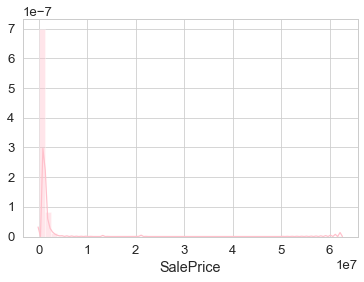

In [26]:
# Can see this is extremely scewed and data outliers need to be treated
sns.distplot(df['SalePrice'], color = "Pink");

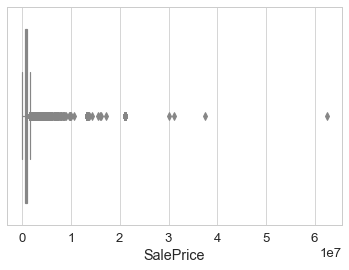

In [27]:
# Cant even see the pink of the box and we can clearly see one particularly large outlier
sns.boxplot(df['SalePrice'], color = "Pink");

In [28]:
# Treating the outliers to include price range of 10000 to 10050000
df2 = df[df['SalePrice'].between(df['SalePrice'].quantile(.004), df['SalePrice'].quantile(.9961))]

In [29]:
print("Sales Price min: ", df2['SalePrice'].min(),
      "\nSales Price max: ", df2['SalePrice'].max(),
      "\nSales Price max: ", df2['SalePrice'].mean())

Sales Price min:  10000 
Sales Price max:  10050000 
Sales Price max:  810713.3477290722


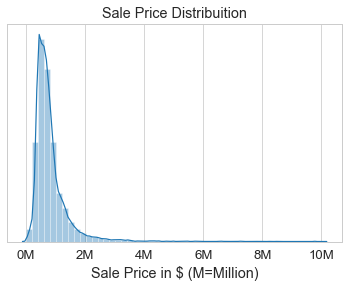

In [30]:
#Plot Sale Price to see if it looks better after treating the outliers
chart = sns.distplot(df2['SalePrice']) #, color = "Purple")
chart.set(xlabel='Sale Price in $ (M=Million)', title='Sale Price Distribuition')
chart.set(yticks=[]) 
xlabels = ['{:,.0f}'.format(x) + 'M' for x in chart.get_xticks()/1000000]
chart.set_xticklabels(xlabels)
plt.savefig("../../reports/figures/Sales_Dist.png", bbox_inches='tight', dpi=1000)

As we can see above, most of the houses fall under $2 million. We chose to include a high range of Sales Prices even though it heavily right skewed the distribution because we wanted to know what features of a house were included in very expensive houses.

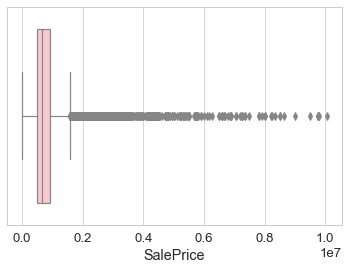

In [31]:
sns.boxplot(df2['SalePrice'], color = "Pink");

In [32]:
# Clean index
df2=df2.reset_index(drop=True)

In [33]:
# Find what Features correlate most with Sale Price and plot some initial EDA visuals
corr_matrix = df2.corr()
print(corr_matrix["SalePrice"].sort_values(ascending=False))

SalePrice                   1.000000
BldgGrade                   0.581476
SqFtTotLiving               0.571867
View_LakeWashington         0.319140
Is_WaterFrontLocation       0.216200
Has_OpenPorch               0.181793
Has_Porch                   0.176378
SeattleSkyline              0.156437
View_Olympics               0.150045
View_LakeSammamish          0.148652
Has_Finished_Basement       0.135054
View_Cascades               0.109642
View_PugetSound             0.098700
Has_Deck                    0.091775
View_MtRainier              0.064629
Minor                       0.048387
Has_Attached_Garage         0.042360
View_SmallLakeRiverCreek    0.030134
SqFtLot                     0.017231
OtherNuisances              0.002900
TrafficNoise                0.002326
Has_Nuisance                0.001070
Has_EnclosedPorch          -0.009422
PowerLines                 -0.014049
Major                      -0.027221
Name: SalePrice, dtype: float64


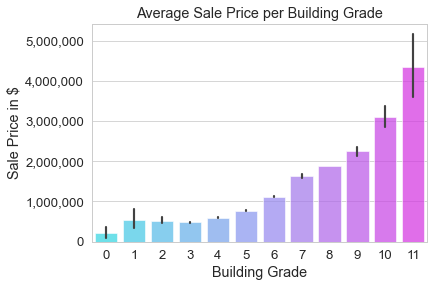

In [45]:
# Building Grade had the highest correlation with Sales Price so we'll start with that
fig = sns.barplot('BldgGrade', 'SalePrice', data=df2, palette="cool", alpha = .7)
fig.set(xlabel='Building Grade', ylabel='Sale Price in $', title='Average Sale Price per Building Grade')
fig.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
fig.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig("../../reports/figures/Building_Grade.png", bbox_inches='tight', dpi=1000)

The building grade (the quality of a house) has a high correlation with the sales price so this feature seems like it will be very statistically significant on our model.

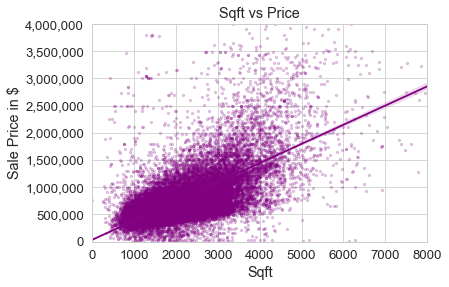

In [35]:
# Scatter plot of Sq Feet vs Sale Price
chart = sns.regplot(x='SqFtTotLiving', y='SalePrice', data=df2,  color = "Purple", scatter_kws={'alpha':0.2, 's': 5})
chart.set(xlabel='Sqft', ylabel='Sale Price in $', title='Sqft vs Price')
chart.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
chart.set(xlim=(0, 8000), ylim=(0, 4000000))
plt.savefig("../../reports/figures/sqftvsPrice.png", bbox_inches='tight', dpi=1000)

Above we adress claim one: Does higher square footage increase sales price? We can see that it does through this scatter plot and a best fit line.

While square feet had quite a high correlation with sale price, however, we cannot include it in our predictive model as it has too much correlation wtih another feature - building grade. The size of the house must be a factor in determining building quality.

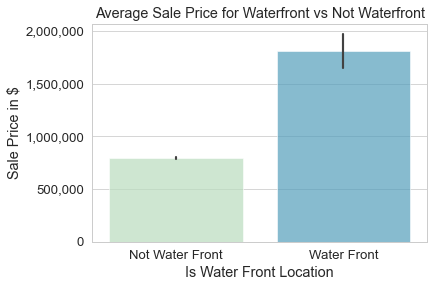

In [36]:
chart = sns.barplot(df2.Is_WaterFrontLocation, df2.SalePrice, palette="GnBu", alpha = .7)
chart.set(xlabel='Is Water Front Location', ylabel='Sale Price in $', title='Average Sale Price for Waterfront vs Not Waterfront')
chart.set_xticklabels(['Not Water Front', 'Water Front'])
chart.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig("../../reports/figures/Is_WaterFront_Loc.png", bbox_inches='tight', dpi=1000)

Now we will adress claim three: Having a beachfront or lakefront increases home sale price? We can see that it clearly does. Waterfront properties are much more expensive on average.

We decided to delve deeper into the features.

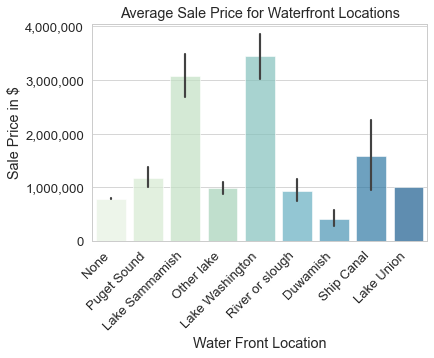

In [37]:
chart = sns.barplot(df2.WaterFrontLocation, df2.SalePrice, palette="GnBu", alpha = .7)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set(xlabel='Water Front Location', ylabel='Sale Price in $', title='Average Sale Price for Waterfront Locations')
chart.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig("../../reports/figures/WaterFront_Loc.png", bbox_inches='tight', dpi=800)

We found that in particular Lake Sammamish and Lake Washington were correlated with high sales prices .

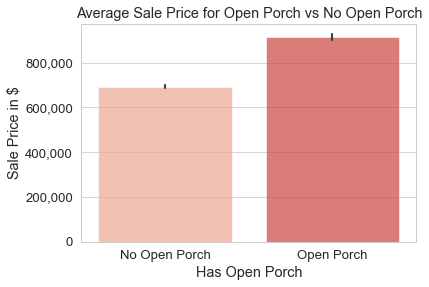

In [38]:
fig = sns.barplot(df2['Has_OpenPorch'], df2['SalePrice'], palette="Reds", alpha = .7);
fig.set(xlabel='Has Open Porch', ylabel='Sale Price in $', title='Average Sale Price for Open Porch vs No Open Porch')
fig.set_xticklabels(['No Open Porch', 'Open Porch'])
fig.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig("../../reports/figures/Has_Open_Porch.png", bbox_inches='tight', dpi=1000);

Now adressing claim two: Having a porch increases home sale price? It does indeed. The average price of a house with a porch is greater than the average price of a house without a porch.

Some more visual explorations:

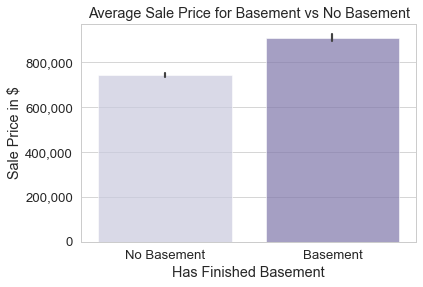

In [39]:
fig = sns.barplot(df2['Has_Finished_Basement'], df2['SalePrice'], palette="Purples",  alpha = .7)
fig.set(xlabel='Has Finished Basement', ylabel='Sale Price in $', title='Average Sale Price for Basement vs No Basement')
fig.set_xticklabels(['No Basement', 'Basement'])
fig.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig("../../reports/figures/Has_Finished_Basement.png", bbox_inches='tight', dpi=1000)

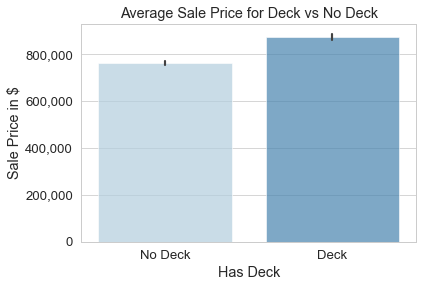

In [40]:
fig = sns.barplot(df2['Has_Deck'], df2['SalePrice'], palette="Blues",  alpha = .7)
fig.set(xlabel='Has Deck', ylabel='Sale Price in $', title='Average Sale Price for Deck vs No Deck')
fig.set_xticklabels(['No Deck', 'Deck'])
fig.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig("../../reports/figures/Has_Deck.png", bbox_inches='tight', dpi=1000)

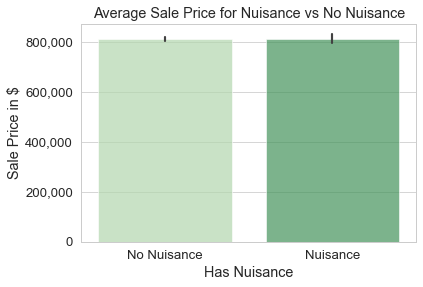

In [41]:
fig = sns.barplot(df2['Has_Nuisance'], df2['SalePrice'], palette="Greens",  alpha = .7)
fig.set(xlabel='Has Nuisance', ylabel='Sale Price in $', title='Average Sale Price for Nuisance vs No Nuisance')
fig.set_xticklabels(['No Nuisance', 'Nuisance'])
fig.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig("../../reports/figures/Nuisances.png", bbox_inches='tight', dpi=1000)

Lastly we adress claim four: The presence of a nuisance (power lines, traffic noise, airport noise) decreases home sale price?

Nuisances don't seem to have much of an effect on Price of House, but we broke down nuisances to further inspect.

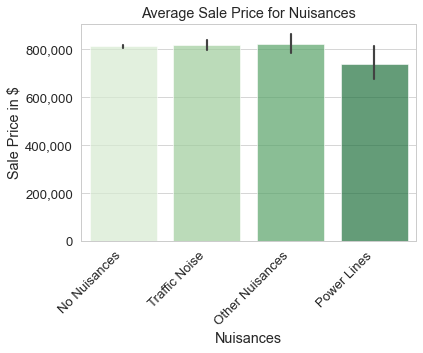

In [42]:
fig = sns.barplot(df2['Nuisances'], df2['SalePrice'], palette="Greens",  alpha = .7)
fig.set(xlabel='Nuisances', ylabel='Sale Price in $', title='Average Sale Price for Nuisances')
fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')
fig.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig("../../reports/figures/Power_Lines.png", bbox_inches='tight', dpi=800)

Aha! While noise and other nuisances dont really affect the sales prices, the presence of power lines do negatively affect the value.


In [65]:
df2.to_csv('../../data/clean/KingCountyHousingData.csv')

NameError: name 'df2' is not defined

# Choropleth Map

In [68]:
import geopandas as gpd
import fiona
import folium

In [70]:
# !pip install geopandas

In [69]:
# Read the data file provided by Clean Data section above

data = pd.read_csv("../../data/clean/KingCountyHousingData.csv", index_col = 0)

In [5]:
data.head()

,Major,Minor,ZipCode,DocumentDate,SalePrice,SqFtLot,SqFtTotLiving,Nuisances,Has_Nuisance,TrafficNoise,...,View_Cascades,SeattleSkyline,View_PugetSound,View_LakeWashington,View_LakeSammamish,View_SmallLakeRiverCreek,BldgGrade,Has_Deck,Has_Finished_Basement,Has_Attached_Garage
0,100,67,98002,2019-04-01,310800,17400,2240,No Nuisances,0,0,...,0,0,0,0,0,0,6.0,0,0,1
1,100,66,98002,2019-10-22,339000,14500,1200,No Nuisances,0,0,...,0,0,0,0,0,0,5.0,0,0,1
2,100,42,98002,2019-10-29,485500,6002,2134,No Nuisances,0,0,...,0,0,0,0,0,0,5.0,0,0,1
3,120,8,98166,2019-05-17,850000,24142,3500,No Nuisances,0,0,...,0,0,0,0,0,0,6.0,1,1,0
4,140,27,98178,2019-05-28,535000,14208,2170,Traffic Noise,1,1,...,0,0,0,0,0,0,5.0,1,1,0


In [71]:
# Create data frame that include only data needed for map

df_map = data[['ZipCode', 'SalePrice']]
df_map

,ZipCode,SalePrice
0,98002,310800
1,98002,339000
2,98002,485500
3,98166,850000
4,98178,535000
...,...,...
27781,98033,3125000
27782,98055,245000
27783,98166,1275000
27784,98166,435000


In [72]:
df_map['SalePrice'].max()

10050000

In [73]:
# Sort by ZipCode

df_map = df_map.sort_values('ZipCode')

In [74]:
df_map_mean = df_map.groupby('ZipCode').mean()
df_map_mean.head(20)

,SalePrice
ZipCode,
89045,1.032976e+06
91844,8.200000e+05
95059,7.378429e+05
98001,4.406618e+05
98002,4.052143e+05
98003,4.621811e+05
98004,2.412158e+06
98005,1.279316e+06
98006,1.186221e+06


In [75]:
df_map_mean.at[98022, 'SalePrice']

498776.5171717172

In [76]:
df_map_mean.index.name = 'ZIPCODE'
df_map_mean

,SalePrice
ZIPCODE,
89045,1.032976e+06
91844,8.200000e+05
95059,7.378429e+05
98001,4.406618e+05
98002,4.052143e+05
...,...
98288,2.564433e+05
98302,8.062417e+05
98354,3.860030e+05


In [77]:
df_map_mean = df_map_mean.reset_index()
df_map_mean

,ZIPCODE,SalePrice
0,89045,1.032976e+06
1,91844,8.200000e+05
2,95059,7.378429e+05
3,98001,4.406618e+05
4,98002,4.052143e+05
...,...,...
86,98288,2.564433e+05
87,98302,8.062417e+05
88,98354,3.860030e+05
89,98405,8.958280e+05


In [78]:
exclude_zipcode = [89045, 91844, 95059, 98012, 98321, 98354, 98405]

In [79]:
df_map_mean1 = df_map_mean[~df_map_mean.isin(exclude_zipcode)]
df_map_mean = df_map_mean1.dropna()

In [80]:
df_map_mean

,ZIPCODE,SalePrice
3,98001.0,4.406618e+05
4,98002.0,4.052143e+05
5,98003.0,4.621811e+05
6,98004.0,2.412158e+06
7,98005.0,1.279316e+06
...,...,...
84,98199.0,1.129775e+06
85,98224.0,3.204833e+05
86,98288.0,2.564433e+05
87,98302.0,8.062417e+05


In [81]:
len(df_map_mean)

85

In [82]:
zipfile = "zip:///Users/romanokonesnikov/Downloads/Zip_Codes-shp.zip/Zip_Codes.shp"

In [83]:
df_zipcode = gpd.read_file(zipfile)

DriverError: '/vsizip//Users/romanokonesnikov/Downloads/Zip_Codes-shp.zip/Zip_Codes.shp' does not exist in the file system, and is not recognized as a supported dataset name.

In [84]:
df_zipcode = df_zipcode.sort_values('ZIPCODE')
df_zipcode

NameError: name 'df_zipcode' is not defined

In [85]:
df_zipcode['ZIPCODE'] = df_zipcode['ZIPCODE'].astype(int)

NameError: name 'df_zipcode' is not defined

In [86]:
df_map_choropleth = df_zipcode.merge(df_map_mean, on='ZIPCODE')
df_map_choropleth

NameError: name 'df_zipcode' is not defined

In [ ]:
# King County coordinates

coordinates = [47.5480, -121.9836]
# 47.5480° N, 121.9836° W
kc_latitude = coordinates[0]
kc_longitude = coordinates[1]

In [ ]:
tooltip_text = []
for i in range(len(df_map_choropleth)):
    tooltip_text.append('$' + str(round(df_map_choropleth['SalePrice'][i], 2)))
tooltip_text
   

In [ ]:
df_map_choropleth = df_map_choropleth.assign(C=tooltip_text)
df_map_choropleth

In [ ]:
# Create .geojson file

df_map_choropleth.to_file("zipcode_map.geojson", driver='GeoJSON')

In [ ]:
# Access the .geojson file

overlay = os.path.join('zipcode_map.geojson')

In [ ]:
KC_WA_map = folium.Map([kc_latitude, kc_longitude])

choropleth = folium.Choropleth(
    geo_data=overlay, 
    #name='choropleth',
    data=df_map_choropleth,
    columns=('ZIPCODE', 'SalePrice'),
    key_on='feature.properties.ZIPCODE',
    fill_color='YlOrBr',
    fill_opacity=0.8,
    nan_fill_color='black',
    nan_fill_opacity=0.4,
    #line_weight=2,
    line_opacity=0.2,
    legend_name='Sale Price per ZipCode in King County, WA',
    highlight=True,
    reset=True
).add_to(KC_WA_map)

folium.LayerControl().add_to(KC_WA_map)


# Display Region Label
choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['ZIPCODE', 'C'], labels=False))


In [ ]:
KC_WA_map

In [ ]:
#Generate map

KC_WA_map.save('King_County_WA_map.html')

# Modeling

## Import Libraries


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan

import scipy.stats as stats

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

## Data Pre-Processing

#### The data was pulled, organized, and cleaned in the data engineering and EDA phase.  In the modeling phase, we broke out some of the features into their own columns to better understand the signficance of that type of feature. These were their own data frames, which we then merged with the main data frame to begin initial models.

In [5]:
#calling in the cleaned data
df = pd.read_csv('../../data/clean/KingCountyHousingData.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27786 entries, 0 to 27785
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                27786 non-null  int64  
 1   Major                     27786 non-null  int64  
 2   Minor                     27786 non-null  int64  
 3   ZipCode                   27786 non-null  int64  
 4   DocumentDate              27786 non-null  object 
 5   SalePrice                 27786 non-null  int64  
 6   SqFtLot                   27786 non-null  int64  
 7   SqFtTotLiving             27786 non-null  int64  
 8   Nuisances                 27786 non-null  object 
 9   Has_Nuisance              27786 non-null  int64  
 10  TrafficNoise              27786 non-null  int64  
 11  PowerLines                27786 non-null  int64  
 12  OtherNuisances            27786 non-null  int64  
 13  Is_WaterFrontLocation     27786 non-null  int64  
 14  WaterF

In [7]:
#creating dummies of Water Front Location, dropping None (doesn't have water front location)
df_water_dummie =pd.get_dummies(df['WaterFrontLocation'])
df_water_dummie.drop('None', axis= 1, inplace=True)
df_water_dummie.head()

,Duwamish,Lake Sammamish,Lake Union,Lake Washington,Other lake,Puget Sound,River or slough,Ship Canal
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0


In [8]:
#creating dummies of Building Grade, dropping lowest grade--> 1= 'poor'
df_bldg_dummie = pd.get_dummies(df['BldgGrade'])
df_bldg_dummie.drop(1, axis= 1, inplace=True) 
df_bldg_dummie.head()

,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0


In [9]:
#merge data frames
comb_df = pd.concat([df, df_water_dummie, df_bldg_dummie], axis=1)
comb_df.head()

,Unnamed: 0,Major,Minor,ZipCode,DocumentDate,SalePrice,SqFtLot,SqFtTotLiving,Nuisances,Has_Nuisance,...,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
0,0,100,67,98002,2019-04-01,310800,17400,2240,No Nuisances,0,...,0,0,0,1,0,0,0,0,0,0
1,1,100,66,98002,2019-10-22,339000,14500,1200,No Nuisances,0,...,0,0,1,0,0,0,0,0,0,0
2,2,100,42,98002,2019-10-29,485500,6002,2134,No Nuisances,0,...,0,0,1,0,0,0,0,0,0,0
3,3,120,8,98166,2019-05-17,850000,24142,3500,No Nuisances,0,...,0,0,0,1,0,0,0,0,0,0
4,4,140,27,98178,2019-05-28,535000,14208,2170,Traffic Noise,1,...,0,0,1,0,0,0,0,0,0,0


In [10]:
#re-name dummie columns 
comb_df = comb_df.rename(columns={"Other lake": "Other_lake","Lake Sammamish":"Lake_Sammamish", 
                                  "Lake Union": "Lake_Union", "Lake Washington": "Lake_Washington", 
                                  "Puget Sound": "Puget_Sound", "River or slough":"River_or_slough", 
                                  "Ship Canal": "Ship_Canal", 2:'Low', 3:'Fair', 4:'Low_Average', 5:'Average',
                                  6 : 'Good', 7 : 'Better', 8 : 'Very_Good', 9 : 'Cabin', 10 : 'Excellent', 11 : 'Luxury', 12 : 'Mansion'})

comb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27786 entries, 0 to 27785
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                27786 non-null  int64  
 1   Major                     27786 non-null  int64  
 2   Minor                     27786 non-null  int64  
 3   ZipCode                   27786 non-null  int64  
 4   DocumentDate              27786 non-null  object 
 5   SalePrice                 27786 non-null  int64  
 6   SqFtLot                   27786 non-null  int64  
 7   SqFtTotLiving             27786 non-null  int64  
 8   Nuisances                 27786 non-null  object 
 9   Has_Nuisance              27786 non-null  int64  
 10  TrafficNoise              27786 non-null  int64  
 11  PowerLines                27786 non-null  int64  
 12  OtherNuisances            27786 non-null  int64  
 13  Is_WaterFrontLocation     27786 non-null  int64  
 14  WaterF

## Correlation Check

#### Now that we had the initial list of significant factors based on the EDA, and seperated out into more detail the Building Grade and Is Water Front Location, we wanted to see all of the factors correlation to Sales Price.

In [11]:
# print list of correlation to Sale Price
corr_matrix = comb_df.corr()
print(corr_matrix["SalePrice"].sort_values(ascending=False))

SalePrice                   1.000000
BldgGrade                   0.581476
SqFtTotLiving               0.571867
Very_Good                   0.319422
View_LakeWashington         0.319140
Excellent                   0.295884
Lake_Washington             0.282498
Luxury                      0.253635
Is_WaterFrontLocation       0.216200
Better                      0.205022
Has_OpenPorch               0.181793
Has_Porch                   0.176378
Mansion                     0.170746
SeattleSkyline              0.156437
View_Olympics               0.150045
View_LakeSammamish          0.148652
Lake_Sammamish              0.142783
Has_Finished_Basement       0.135054
View_Cascades               0.109642
View_PugetSound             0.098700
Has_Deck                    0.091775
View_MtRainier              0.064629
Minor                       0.048387
Has_Attached_Garage         0.042360
Puget_Sound                 0.034046
View_SmallLakeRiverCreek    0.030134
Other_lake                  0.020896
S

## Model Testing

### Model 1- Base Model
 
#### Given that this list of features has already been paired down based on initial analysis during the EDA phase, we wanted to include all of the features into the first model. 
 
#### The results of this model were:
  #### -An R-squared: .506
  #### -Many features that were not statistically significant, with p-values above .05
  #### -It is not normally distributed
  #### -The variance of residuals (errors) is not distributed equally
  #### -High multicollinearity
  #### -Passes linearity Rainbow test with a p-value of .0284
  
 

In [33]:
# Baseline model with all features
outcome = 'SalePrice'      
x_cols =['SqFtLot',
 'SqFtTotLiving',            
 'Nuisances',           
 'Has_Nuisance',             
 'TrafficNoise',             
 'PowerLines',               
 'OtherNuisances',           
 'Is_WaterFrontLocation',    
 'WaterFrontLocation',       
 'Has_Porch',                
 'Has_OpenPorch',            
 'Has_EnclosedPorch',        
 'View_MtRainier',           
 'View_Olympics',            
 'View_Cascades',            
 'SeattleSkyline',           
 'View_PugetSound',          
 'View_LakeWashington',      
 'View_LakeSammamish',       
 'View_SmallLakeRiverCreek', 
 'BldgGrade',                
 'Has_Deck',                 
 'Has_Finished_Basement',    
 'Has_Attached_Garage',      
 'Duwamish',                 
 'Lake_Sammamish',           
 'Lake_Union',               
 'Lake_Washington',          
 'Other_lake',               
 'Puget_Sound',              
 'River_or_slough',          
 'Ship_Canal',               
 'Low',                      
 'Fair',                     
 'Low_Average',              
 'Average',                  
 'Good',                     
 'Better',                   
 'Very_Good',                
 'Cabin',                    
 'Excellent',                
 'Luxury',                 
 'Mansion']                  

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model1 = ols(formula=formula, data=comb_df).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     711.7
Date:                Sun, 04 Oct 2020   Prob (F-statistic):               0.00
Time:                        09:22:54   Log-Likelihood:            -3.9976e+05
No. Observations:               27786   AIC:                         7.996e+05
Df Residuals:                   27745   BIC:                         7.999e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                              1.513e+04   1.56e+05      0.097      0.923   -2.91e+05    3.21e+05
Nuisances[T.Other Nuisances]           2.106e+04    1.8e+04      1.173      0.241   -1.41e+04    5.63e+04
Nuisances[T.Power Lines]               5.032e+04   8.75e+04      0.575      0.565   -1.21e+05    2.22e+05
Nuisances[T.Traffic Noise]            -1.205e+04    3.7e+04     -0.325      0.745   -8.46e+04    6.05e+04
WaterFrontLocation[T.Lake Sammamish]   5.924e+05   5.65e+04     10.476      0.000    4.82e+05    7.03e+05
WaterFrontLocation[T.Lake Union]       9.426e+04   1.96e+05      0.481      0.630    -2.9e+05    4.78e+05
WaterFrontLocation[T.Lake Washington]  4.654e+05   4.18e+04     11.133      0.000    3.83e+05    5.47e+05
WaterFrontLocation[T.None]            -1.736e+05    8.8e+04     -1.974      0.048   -3.46e+05   -1184.283
WaterFrontLocation[T.Other lake]      -2.281e+05   3.97e+04     -5.745      0.000   -3.06e+05    -1.5e+05
WaterFrontLocation[T.Puget Sound]     -8.683e+04   4.24e+04     -2.048      0.041    -1.7e+05   -3724.888
WaterFrontLocation[T.River or slough] -1.952e+05   4.04e+04     -4.831      0.000   -2.74e+05   -1.16e+05
WaterFrontLocation[T.Ship Canal]       8.776e+04   8.25e+04      1.063      0.288    -7.4e+04     2.5e+05
SqFtLot                                  -0.0006      0.019     -0.029      0.977      -0.038       0.037
SqFtTotLiving                           183.7647      4.286     42.871      0.000     175.363     192.166
Has_Nuisance                           5.934e+04   3.58e+04      1.656      0.098   -1.09e+04     1.3e+05
TrafficNoise                          -2.048e+04   9910.562     -2.067      0.039   -3.99e+04   -1057.770
PowerLines                            -1.867e+05    1.2e+05     -1.556      0.120   -4.22e+05    4.85e+04
OtherNuisances                         2.106e+04    1.8e+04      1.173      0.241   -1.41e+04    5.63e+04
Is_WaterFrontLocation                  1.888e+05   8.35e+04      2.262      0.024    2.52e+04    3.52e+05
Has_Porch                              8959.1158   2.49e+04      0.359      0.719   -3.99e+04    5.78e+04
Has_OpenPorch                          5621.4501   2.43e+04      0.231      0.817   -4.21e+04    5.33e+04
Has_EnclosedPorch                      1.071e+04   1.93e+04      0.555      0.579   -2.71e+04    4.85e+04
View_MtRainier                        -2.699e+04   1.07e+04     -2.533      0.011   -4.79e+04   -6105.611
View_Olympics                          5.009e+04   9062.991      5.527      0.000    3.23e+04    6.79e+04
View_Cascades                         -1.446e+04   7122.432     -2.031      0.042   -2.84e+04    -503.403
SeattleSkyline                          3.43e+05    2.9e+04     11.828      0.000    2.86e+05       4e+05
View_Puge

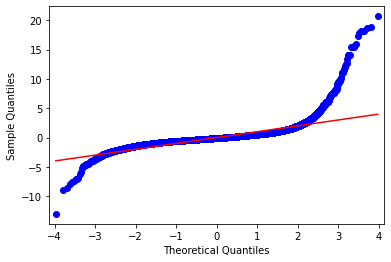

In [34]:
#Checking for distribution normality
fig = sm.graphics.qqplot(model1.resid, line='s',dist=stats.norm, fit=True)

#result: not normally distributed with large tails and two distict outliers on either end

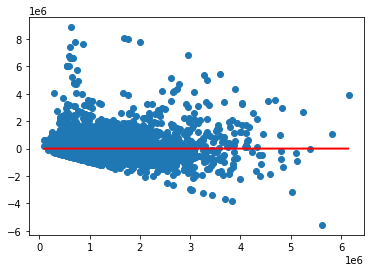

In [35]:
#Homoscedasticity--checking for variance of residuals (errors)
plt.scatter(model1.predict(comb_df[x_cols]), model1.resid)
plt.plot(model1.predict(comb_df[x_cols]), [0 for i in range(len(comb_df))], color='red');

#result: variance of residuals not evenly distributed

In [36]:
#Testing for linearity
rainbow_statistic, rainbow_p_value = linear_rainbow(model1)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.0328758264135403
Rainbow p-value: 0.028396049659178135


### Model 2 - Model Improvement


 
#### This next model takes the base model and removes features with a p-value over .05 
#### Removing: 'Nuisances', 'OtherNuisances', 'Lake_Union', 'Fair', 'SqFtLot', 'WaterFrontLocation', ,  'Has_Porch','Has_OpenPorch', 'Has_Nuisance', 'PowerLines', 'Has_EnclosedPorch', 'View_LakeSammamish',  'Has_Deck', 'Ship_Canal', 'Low',  'Cabin',  'Luxury'
#### Once the model was run, new p-values over .05 were commented out and the model run again. Those removed from the model were:'View_Cascades', 'View_PugetSound', 'TrafficNoise'
 
#### The results of this model were:
  #### -An R-squared: .505
  #### -It is not normally distributed
  #### -The variance of residuals (errors) is not distributed equally
  #### -High multicollinearity
  #### -Passes linearity Rainbow test with a p-value of .0303
 

In [42]:
outcome = 'SalePrice'      
x_cols =[
 'SqFtTotLiving',
  'Is_WaterFrontLocation',           
 'SeattleSkyline',                     
 'View_LakeWashington',             
 'View_SmallLakeRiverCreek',
     'View_MtRainier',           
 'View_Olympics',  
#'View_Cascades',
    #'View_PugetSound',
 'BldgGrade',                           
 'Has_Finished_Basement',    
 'Has_Attached_Garage',      
 'Duwamish',
 #'TrafficNoise',
 'Lake_Sammamish',              
 'Lake_Washington',          
 'Other_lake',               
 'Puget_Sound',              
 'River_or_slough',                                   
 'Low_Average',              
 'Average',                  
 'Good',                     
 'Better',                   
 'Very_Good',                                    
 'Excellent',                               
 'Mansion']                  

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model2 = ols(formula=formula, data=comb_df).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     1231.
Date:                Sun, 04 Oct 2020   Prob (F-statistic):               0.00
Time:                        09:32:22   Log-Likelihood:            -3.9981e+05
No. Observations:               27786   AIC:                         7.997e+05
Df Residuals:                   27762   BIC:                         7.999e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -2.103e+05   3.43e+04     -6.123      0.000   -2.78e+05   -1.43e+05
SqFtTotLiving              185.1267      4.117     44.962      0.000     177.056     193.197
Is_WaterFrontLocation     5.977e+05   1.58e+05      3.772      0.000    2.87e+05    9.08e+05
SeattleSkyline            3.365e+05    2.9e+04     11.606      0.000     2.8e+05    3.93e+05
View_LakeWashington       1.537e+05   8348.547     18.407      0.000    1.37e+05     1.7e+05
View_SmallLakeRiverCreek  4.721e+04   1.51e+04      3.135      0.002    1.77e+04    7.67e+04
View_MtRainier           -3.097e+04   1.04e+04     -2.991      0.003   -5.13e+04   -1.07e+04
View_Olympics             6.091e+04   7011.193      8.688      0.000    4.72e+04    7.47e+04
BldgGrade                 1.899e+05   5945.238     31.944      0.000    1.78e+05    2.02e+05
Has_Finished_Basement     2.409e+04   6017.146      4.003      0.000    1.23e+04    3.59e+04
Has_Attached_Garage      -1.548e+05   6176.834    -25.058      0.000   -1.67e+05   -1.43e+05
Duwamish                 -7.941e+05   2.91e+05     -2.726      0.006   -1.37e+06   -2.23e+05
Lake_Sammamish            1.023e+06   1.72e+05      5.940      0.000    6.85e+05    1.36e+06
Lake_Washington            7.24e+05   1.66e+05      4.360      0.000    3.99e+05    1.05e+06
Other_lake               -6.892e+05   1.57e+05     -4.402      0.000   -9.96e+05   -3.82e+05
Puget_Sound              -3.557e+05   1.65e+05     -2.156      0.031   -6.79e+05   -3.23e+04
River_or_slough          -6.202e+05    1.6e+05     -3.866      0.000   -9.35e+05   -3.06e+05
Low_Average              -2.826e+05   2.26e+04    -12.528      0.000   -3.27e+05   -2.38e+05
Average                  -4.161e+05   2.06e+04    -20.206      0.000   -4.56e+05   -3.76e+05
Good                     -5.112e+05   2.13e+04    -24.022      0.000   -5.53e+05   -4.69e+05
Better                   -4.923e+05   2.36e+04    -20.824      0.000   -5.39e+05   -4.46e+05
Very_Good                 -3.39e+05   2.79e+04    -12.149      0.000   -3.94e+05   -2.84e+05
Excellent                -3.487e+05   3.93e+04     -8.865      0.000   -4.26e+05   -2.72e+05
Mansion                   3.983e+05    9.8e+04      4.062      0.000    2.06e+05     5.9e+05
==============================================================================
Omnibus:                    29355.018   Durbin-Watson:                   1.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5656830.872
Skew:                           4.954   Prob(JB):                         0.00
Kurtosis:                      72.195   Cond. No.                     4.01e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specif

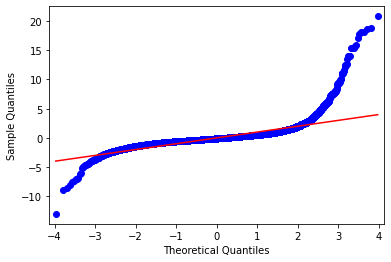

In [43]:
#Checking for distribution normality
fig = sm.graphics.qqplot(model2.resid, line='s',dist=stats.norm, fit=True)

#results: no significant improvement

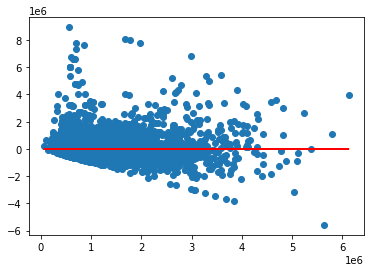

In [45]:
#Homoscedasticity--checking for variance of residuals (errors)
plt.scatter(model2.predict(comb_df[x_cols]), model2.resid)
plt.plot(model2.predict(comb_df[x_cols]), [0 for i in range(len(comb_df))], color ='red');

#result: similiar to Model 1, uneven distribution

In [46]:
#Testing for linearity
rainbow_statistic, rainbow_p_value = linear_rainbow(model2)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.0323552769646274
Rainbow p-value: 0.03034560156036285


In [60]:
#Checking for multi-collinearity
X = comb_df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

#several features with high multi-collinearity

[('Very_Good', 1.174081380847239),
 ('View_LakeWashington', 1.6953446058248414),
 ('Excellent', 1.0798003423010987),
 ('Lake_Washington', 1.5745444992778448),
 ('Has_Attached_Garage', 1.9205209937546341),
 ('Luxury', 1.0370667889932788),
 ('PowerLines', 1.0125690452352096),
 ('Better', 1.3717867231065546),
 ('Has_Porch', 1.999350543535469),
 ('Mansion', 1.0236714262545683),
 ('SeattleSkyline', 1.1133974860035136),
 ('View_Olympics', 1.8588471573067729),
 ('View_MtRainier', 1.0549043145462849),
 ('Lake_Sammamish', 1.0098235120844945),
 ('Has_Finished_Basement', 1.445664530521855),
 ('View_PugetSound', 1.7936891775146435),
 ('View_SmallLakeRiverCreek', 1.0101737562642685),
 ('Low_Average', 1.0488789050365173),
 ('Average', 1.5005324287833162)]

### Model 3 - Model Improvement

#### Based on Model 2, knew that still had high multicollinearity. Removed 'Is Water Front Location' and 'Building Grade' because broke these out into dummie columns and using that more detailed view. Using both sets of groupped and dummies adds to mullti-collinearity. 

#### From the EDA, we knew that 'Total Square Foot Living' had a significant impact on Sale Price.  Wanted to see how this feature realated to the other ones, so made a correlation matrix. This showed the correlation to other features such as homes with building grades of very high, excellent, Mansion, and with additional features such as garage, porch.  This makes sense because many of the homes with high sales price have these features and these tend to have high square footage. Given the high multicollinearity, we removed this total square food living from the model.

#### Also from the EDA, we knew that 'Power Lines' did have an impact on sales price and is one of the claims we set out address and so put it back in to see if given the new improved model, it would be statistically significant and found that it was. 

#### The results of this model were:
  #### -An R-squared: .470
  #### -It is not normally distributed
  #### -The variance of residuals (errors) is not distributed equally
  #### -No multicollinearity: VIF all under 5, and condition number significantly decreased
  #### -Passes linearity Rainbow test with a p-value of .0428
  



In [50]:
#data frame based on model 2 features to test remaining features against total square foot living.

df_sqrtotal = comb_df[['SqFtTotLiving', 
         'Very_Good',
          'View_LakeWashington',
         'Excellent',  
         'Lake_Washington', 'Has_Attached_Garage',
         'Luxury', 'PowerLines',
         'Better',
         'Has_Porch','Has_Deck',
         'Mansion',
 'SeattleSkyline', 
         'View_Olympics', 'View_MtRainier',
         'Lake_Sammamish',
          'Has_Finished_Basement',
 'View_PugetSound',          
 'View_SmallLakeRiverCreek',                                   
 'Low_Average',              
 'Average']]    

In [48]:
#Correlation of features to Square foot living
corr_matrix = df_sqrtotal.corr()
print(corr_matrix["SqFtTotLiving"].sort_values(ascending=False))

SqFtTotLiving               1.000000
Very_Good                   0.356228
Has_Porch                   0.326771
Has_Attached_Garage         0.324302
Better                      0.317124
Excellent                   0.293321
Luxury                      0.234352
View_LakeWashington         0.158712
Mansion                     0.151901
Has_Finished_Basement       0.128116
View_Olympics               0.111656
Lake_Washington             0.094026
SeattleSkyline              0.084583
View_PugetSound             0.064992
Has_Deck                    0.063462
View_MtRainier              0.061952
Lake_Sammamish              0.052871
PowerLines                  0.019450
View_SmallLakeRiverCreek    0.018001
Low_Average                -0.308539
Average                    -0.349062
Name: SqFtTotLiving, dtype: float64


In [54]:
#Model 3
outcome = 'SalePrice'      
x_cols =[  'Very_Good',
          'View_LakeWashington',
         'Excellent',  
         'Lake_Washington', 'Has_Attached_Garage',
         'Luxury', 
    'PowerLines',
         'Better',
         'Has_Porch',
         'Mansion',
 'SeattleSkyline', 
         'View_Olympics', 'View_MtRainier',
         'Lake_Sammamish',
          'Has_Finished_Basement',
 'View_PugetSound',          
 'View_SmallLakeRiverCreek',                                   
 'Low_Average',              
 'Average']                  

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model3 = ols(formula=formula, data=comb_df).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     1294.
Date:                Sun, 04 Oct 2020   Prob (F-statistic):               0.00
Time:                        09:50:37   Log-Likelihood:            -4.0076e+05
No. Observations:               27786   AIC:                         8.016e+05
Df Residuals:                   27766   BIC:                         8.017e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 6.961e+05   7762.118     89.682      0.000    6.81e+05    7.11e+05
Very_Good                 7.966e+05   1.27e+04     62.935      0.000    7.72e+05    8.21e+05
View_LakeWashington       1.733e+05   8701.147     19.914      0.000    1.56e+05     1.9e+05
Excellent                 1.302e+06   2.21e+04     58.807      0.000    1.26e+06    1.35e+06
Lake_Washington           1.245e+06   5.13e+04     24.246      0.000    1.14e+06    1.35e+06
Has_Attached_Garage      -7.198e+04   6082.755    -11.834      0.000   -8.39e+04   -6.01e+04
Luxury                    2.036e+06   4.02e+04     50.679      0.000    1.96e+06    2.11e+06
PowerLines               -6.618e+04   2.61e+04     -2.540      0.011   -1.17e+05   -1.51e+04
Better                    3.317e+05   8488.539     39.077      0.000    3.15e+05    3.48e+05
Has_Porch                 7.634e+04   5694.890     13.404      0.000    6.52e+04    8.75e+04
Mansion                    2.96e+06   9.18e+04     32.245      0.000    2.78e+06    3.14e+06
SeattleSkyline            3.121e+05      3e+04     10.417      0.000    2.53e+05    3.71e+05
View_Olympics             5.798e+04   9193.399      6.306      0.000       4e+04     7.6e+04
View_MtRainier           -2.287e+04   1.08e+04     -2.119      0.034    -4.4e+04   -1717.248
Lake_Sammamish            1.664e+06   6.98e+04     23.853      0.000    1.53e+06     1.8e+06
Has_Finished_Basement     1.075e+05   6050.297     17.768      0.000    9.56e+04    1.19e+05
View_PugetSound           3.102e+04   8886.728      3.490      0.000    1.36e+04    4.84e+04
View_SmallLakeRiverCreek  3.345e+04   9966.145      3.356      0.001    1.39e+04     5.3e+04
Low_Average              -2.679e+05   1.07e+04    -25.007      0.000   -2.89e+05   -2.47e+05
Average                  -1.583e+05   6505.426    -24.337      0.000   -1.71e+05   -1.46e+05
==============================================================================
Omnibus:                    28494.711   Durbin-Watson:                   1.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4549787.269
Skew:                           4.763   Prob(JB):                         0.00
Kurtosis:                      64.961   Cond. No.                         49.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

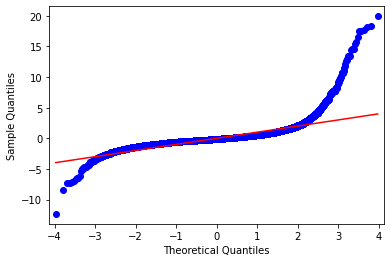

In [55]:
#Checking for distribution normality
fig = sm.graphics.qqplot(model4.resid, line='s',dist=stats.norm, fit=True)

#result: not normally distributed

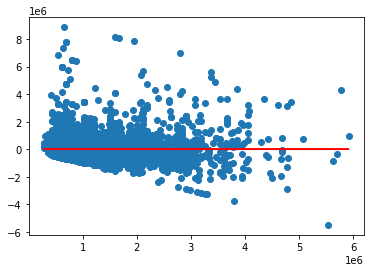

In [61]:
#Homoscedasticity--checking for variance of residuals (errors)
plt.scatter(model3.predict(comb_df[x_cols]), model3.resid)
plt.plot(model3.predict(comb_df[x_cols]), [0 for i in range(len(comb_df))],color ='red');


In [63]:
#Testing for linearity
rainbow_statistic, rainbow_p_value = linear_rainbow(model3)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.0323552769646274
Rainbow p-value: 0.03034560156036285


In [62]:
#Checking for multi-collinearity
X = comb_df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))


[('Very_Good', 1.174081380847239),
 ('View_LakeWashington', 1.6953446058248414),
 ('Excellent', 1.0798003423010987),
 ('Lake_Washington', 1.5745444992778448),
 ('Has_Attached_Garage', 1.9205209937546341),
 ('Luxury', 1.0370667889932788),
 ('PowerLines', 1.0125690452352096),
 ('Better', 1.3717867231065546),
 ('Has_Porch', 1.999350543535469),
 ('Mansion', 1.0236714262545683),
 ('SeattleSkyline', 1.1133974860035136),
 ('View_Olympics', 1.8588471573067729),
 ('View_MtRainier', 1.0549043145462849),
 ('Lake_Sammamish', 1.0098235120844945),
 ('Has_Finished_Basement', 1.445664530521855),
 ('View_PugetSound', 1.7936891775146435),
 ('View_SmallLakeRiverCreek', 1.0101737562642685),
 ('Low_Average', 1.0488789050365173),
 ('Average', 1.5005324287833162)]